In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import numpy as np
import os
#import cv2
from glob import glob
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from IPython.display import Image

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from itertools import cycle
#from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [4]:
import sys
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib


print(f"Python {sys.version}")
print()
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Pandas: {pd.__version__}")
print(f"Scikit-Learn: {sk.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print()
print("GPU is ", "available" if tf.config.list_physical_devices('GPU') else "not available")
print(f"CUDA: {tf.test.is_built_with_cuda()}")

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]

Tensorflow version: 2.9.1
Keras Version: 2.9.0

Pandas: 1.4.2
Scikit-Learn: 1.0.2
Numpy: 1.21.5
Matplotlib: 3.5.1

GPU is  available
CUDA: True


In [5]:
!nvidia-smi

Mon Jul  4 02:51:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8    12W /  N/A |    255MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [7]:
train_path = 'D:/MScCS/thesis/Dataset/new1/train'
valid_path = 'D:/MScCS/thesis/Dataset/new1/test'

In [8]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [10]:
# useful for getting number of output classes
folders = glob('D:/MScCS/thesis/Dataset/new1/train/*')

In [11]:
folders

['D:/MScCS/thesis/Dataset/new1/train\\cocci',
 'D:/MScCS/thesis/Dataset/new1/train\\healthy',
 'D:/MScCS/thesis/Dataset/new1/train\\ncd',
 'D:/MScCS/thesis/Dataset/new1/train\\salmo']

In [12]:
#layers
x = Flatten()(vgg19.output)

In [13]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [16]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range= 15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
training_set = train_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new1/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

Found 748 images belonging to 4 classes.


In [18]:
test_set = test_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new1/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')


Found 252 images belonging to 4 classes.


In [32]:
itr = test_datagen.flow_from_directory(
'D:/MScCS/thesis/Dataset/new1/test',
target_size=(224,224),
batch_size=8,
class_mode='categorical')

#X, y = itr.next()
x_test, y_test = itr.next()

n_classes = 4
lw = 2

Found 252 images belonging to 4 classes.


In [25]:
def plot_roc_curve():
    #roc curve plot

    y_score = model.predict(x_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        if(i == 0):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of cocci (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 1):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of healthy (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 2):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of ncd (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 3):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of salmo (area = {1:0.2f})".format(i, roc_auc[i]),
            )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()


In [26]:
def plot_loss_acc():
    # plotting the loss
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='val loss')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

    # plotting the accuracy
    plt.plot(r.history['accuracy'], label='train accuracy')
    plt.plot(r.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

In [22]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
94/94 [==============================] - 50s 425ms/step - loss: 1.0136 - accuracy: 0.6190 - auc: 0.8338 - val_loss: 0.8249 - val_accuracy: 0.6984 - val_auc: 0.9044
Epoch 2/10
94/94 [==============================] - 35s 377ms/step - loss: 0.6858 - accuracy: 0.7781 - auc: 0.9347 - val_loss: 0.6482 - val_accuracy: 0.7976 - val_auc: 0.9484
Epoch 3/10
94/94 [==============================] - 36s 380ms/step - loss: 0.5641 - accuracy: 0.7928 - auc: 0.9562 - val_loss: 0.5793 - val_accuracy: 0.7937 - val_auc: 0.9524
Epoch 4/10
94/94 [==============================] - 35s 377ms/step - loss: 0.4987 - accuracy: 0.8316 - auc: 0.9656 - val_loss: 0.5206 - val_accuracy: 0.8214 - val_auc: 0.9641
Epoch 5/10
94/94 [==============================] - 36s 377ms/step - loss: 0.4452 - accuracy: 0.8489 - auc: 0.9736 - val_loss: 0.4753 - val_accuracy: 0.8413 - val_auc: 0.9681
Epoch 6/10
94/94 [==============================] - 36s 380ms/step - loss: 0.3952 - accuracy: 0.8650 - auc: 0.9808 - val_loss

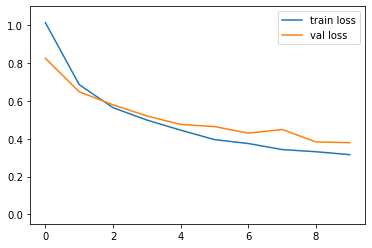

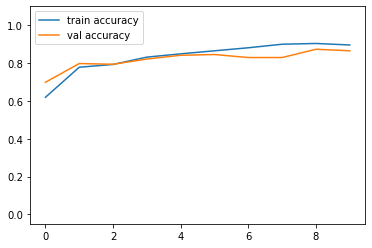

1/1 [==============================] - 0s 25ms/step


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


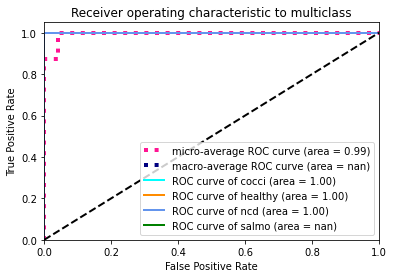

In [28]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_10.h5')

In [26]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/15
94/94 [==============================] - 34s 355ms/step - loss: 0.0834 - accuracy: 0.9853 - auc: 0.9994 - val_loss: 0.3282 - val_accuracy: 0.8571 - val_auc: 0.9806
Epoch 2/15
94/94 [==============================] - 33s 355ms/step - loss: 0.0831 - accuracy: 0.9746 - auc: 0.9994 - val_loss: 0.2517 - val_accuracy: 0.9167 - val_auc: 0.9873
Epoch 3/15
94/94 [==============================] - 33s 357ms/step - loss: 0.0849 - accuracy: 0.9799 - auc: 0.9993 - val_loss: 0.2805 - val_accuracy: 0.8889 - val_auc: 0.9856
Epoch 4/15
94/94 [==============================] - 33s 357ms/step - loss: 0.0812 - accuracy: 0.9840 - auc: 0.9994 - val_loss: 0.2174 - val_accuracy: 0.9325 - val_auc: 0.9916
Epoch 5/15
94/94 [==============================] - 34s 358ms/step - loss: 0.0811 - accuracy: 0.9813 - auc: 0.9996 - val_loss: 0.2033 - val_accuracy: 0.9365 - val_auc: 0.9925
Epoch 6/15
94/94 [==============================] - 34s 361ms/step - loss: 0.0924 - accuracy: 0.9786 - auc: 0.9988 - val_loss

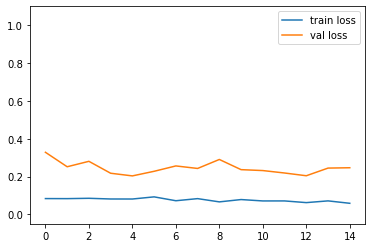

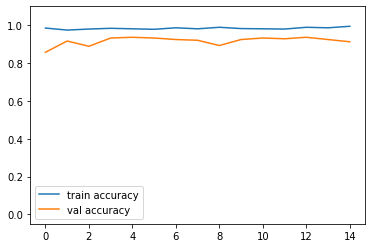

1/1 [==============================] - 0s 25ms/step


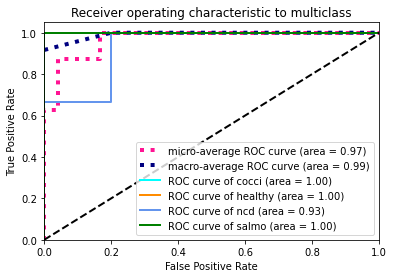

In [27]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_15.h5')

In [22]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
94/94 [==============================] - 34s 361ms/step - loss: 0.2702 - accuracy: 0.9291 - auc: 0.9923 - val_loss: 0.3866 - val_accuracy: 0.8373 - val_auc: 0.9755
Epoch 2/20
94/94 [==============================] - 34s 361ms/step - loss: 0.2746 - accuracy: 0.9144 - auc: 0.9905 - val_loss: 0.3683 - val_accuracy: 0.8929 - val_auc: 0.9803
Epoch 3/20
94/94 [==============================] - 34s 360ms/step - loss: 0.2643 - accuracy: 0.9144 - auc: 0.9924 - val_loss: 0.3984 - val_accuracy: 0.8333 - val_auc: 0.9733
Epoch 4/20
94/94 [==============================] - 34s 359ms/step - loss: 0.2482 - accuracy: 0.9291 - auc: 0.9924 - val_loss: 0.3542 - val_accuracy: 0.8889 - val_auc: 0.9799
Epoch 5/20
94/94 [==============================] - 34s 357ms/step - loss: 0.2511 - accuracy: 0.9238 - auc: 0.9918 - val_loss: 0.3914 - val_accuracy: 0.8413 - val_auc: 0.9739
Epoch 6/20
94/94 [==============================] - 34s 358ms/step - loss: 0.2359 - accuracy: 0.9225 - auc: 0.9931 - val_loss

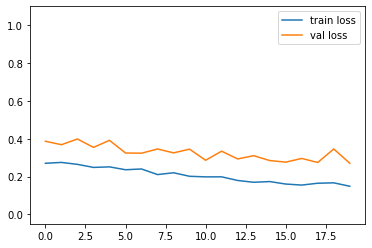

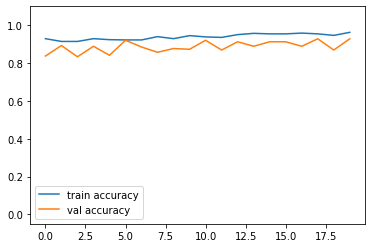

1/1 [==============================] - 0s 160ms/step


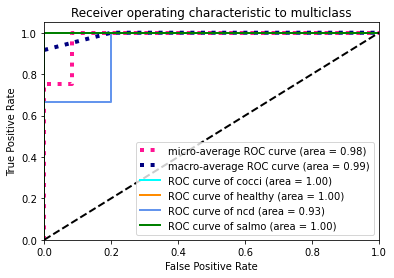

In [23]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_20.h5')

In [24]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
94/94 [==============================] - 35s 367ms/step - loss: 0.1477 - accuracy: 0.9652 - auc: 0.9977 - val_loss: 0.2603 - val_accuracy: 0.9325 - val_auc: 0.9883
Epoch 2/25
94/94 [==============================] - 34s 357ms/step - loss: 0.1360 - accuracy: 0.9706 - auc: 0.9987 - val_loss: 0.2754 - val_accuracy: 0.9167 - val_auc: 0.9867
Epoch 3/25
94/94 [==============================] - 33s 357ms/step - loss: 0.1519 - accuracy: 0.9599 - auc: 0.9975 - val_loss: 0.2806 - val_accuracy: 0.9246 - val_auc: 0.9862
Epoch 4/25
94/94 [==============================] - 34s 360ms/step - loss: 0.1280 - accuracy: 0.9652 - auc: 0.9986 - val_loss: 0.3822 - val_accuracy: 0.8413 - val_auc: 0.9749
Epoch 5/25
94/94 [==============================] - 34s 356ms/step - loss: 0.1276 - accuracy: 0.9666 - auc: 0.9986 - val_loss: 0.2772 - val_accuracy: 0.9127 - val_auc: 0.9862
Epoch 6/25
94/94 [==============================] - 34s 357ms/step - loss: 0.1325 - accuracy: 0.9679 - auc: 0.9981 - val_loss

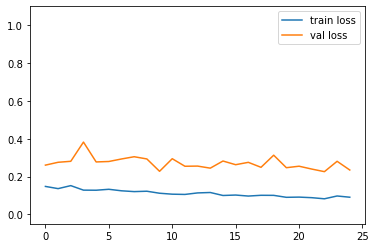

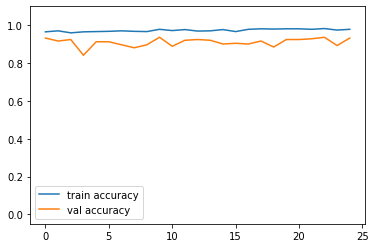

1/1 [==============================] - 0s 24ms/step


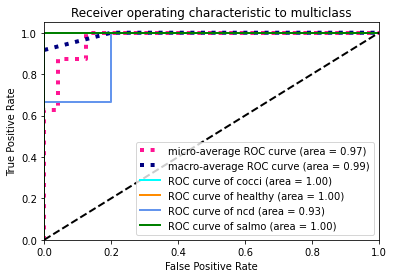

In [25]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg16copy_25.h5')

In [28]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
94/94 [==============================] - 34s 357ms/step - loss: 0.0640 - accuracy: 0.9853 - auc: 0.9997 - val_loss: 0.2738 - val_accuracy: 0.9087 - val_auc: 0.9856
Epoch 2/30
94/94 [==============================] - 33s 357ms/step - loss: 0.0639 - accuracy: 0.9826 - auc: 0.9998 - val_loss: 0.2484 - val_accuracy: 0.9167 - val_auc: 0.9878
Epoch 3/30
94/94 [==============================] - 34s 357ms/step - loss: 0.0550 - accuracy: 0.9906 - auc: 0.9998 - val_loss: 0.2319 - val_accuracy: 0.9286 - val_auc: 0.9890
Epoch 4/30
94/94 [==============================] - 33s 353ms/step - loss: 0.0688 - accuracy: 0.9853 - auc: 0.9997 - val_loss: 0.2883 - val_accuracy: 0.9087 - val_auc: 0.9848
Epoch 5/30
94/94 [==============================] - 34s 360ms/step - loss: 0.0627 - accuracy: 0.9866 - auc: 0.9998 - val_loss: 0.2666 - val_accuracy: 0.9167 - val_auc: 0.9864
Epoch 6/30
94/94 [==============================] - 33s 356ms/step - loss: 0.0627 - accuracy: 0.9866 - auc: 0.9998 - val_loss

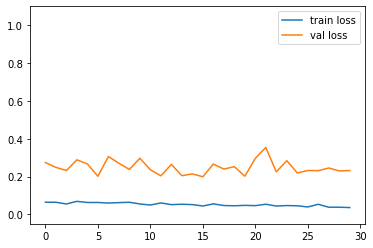

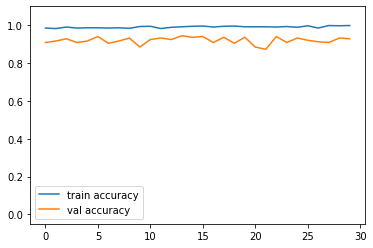

1/1 [==============================] - 0s 25ms/step


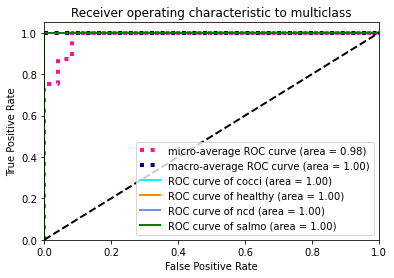

In [29]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_30.h5')

In [30]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/35
94/94 [==============================] - 34s 356ms/step - loss: 0.0391 - accuracy: 0.9920 - auc: 0.9999 - val_loss: 0.2786 - val_accuracy: 0.9048 - val_auc: 0.9862
Epoch 2/35
94/94 [==============================] - 33s 353ms/step - loss: 0.0395 - accuracy: 0.9947 - auc: 1.0000 - val_loss: 0.2697 - val_accuracy: 0.9048 - val_auc: 0.9868
Epoch 3/35
94/94 [==============================] - 33s 353ms/step - loss: 0.0373 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2109 - val_accuracy: 0.9365 - val_auc: 0.9908
Epoch 4/35
94/94 [==============================] - 33s 353ms/step - loss: 0.0347 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2057 - val_accuracy: 0.9405 - val_auc: 0.9911
Epoch 5/35
94/94 [==============================] - 33s 353ms/step - loss: 0.0367 - accuracy: 0.9920 - auc: 1.0000 - val_loss: 0.2384 - val_accuracy: 0.9087 - val_auc: 0.9893
Epoch 6/35
94/94 [==============================] - 33s 352ms/step - loss: 0.0342 - accuracy: 0.9947 - auc: 1.0000 - val_loss

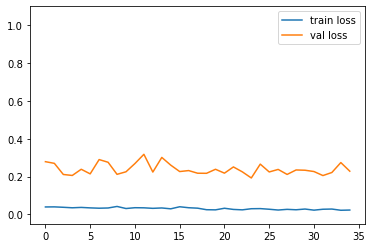

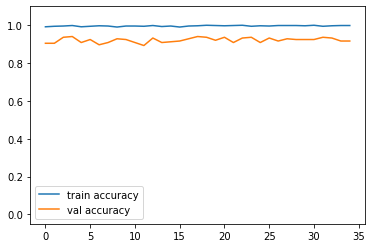

1/1 [==============================] - 0s 25ms/step


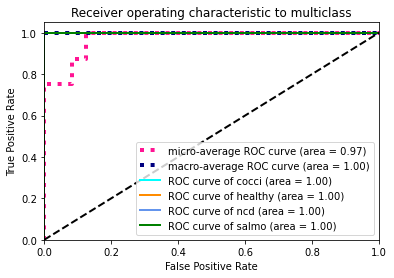

In [31]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_35.h5')

In [32]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/40
94/94 [==============================] - 36s 376ms/step - loss: 0.0186 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2741 - val_accuracy: 0.9127 - val_auc: 0.9855
Epoch 2/40
94/94 [==============================] - 63s 673ms/step - loss: 0.0221 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2558 - val_accuracy: 0.9127 - val_auc: 0.9870
Epoch 3/40
94/94 [==============================] - 74s 754ms/step - loss: 0.0290 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2618 - val_accuracy: 0.9127 - val_auc: 0.9865
Epoch 4/40
94/94 [==============================] - 35s 376ms/step - loss: 0.0239 - accuracy: 0.9947 - auc: 1.0000 - val_loss: 0.2442 - val_accuracy: 0.9206 - val_auc: 0.9869
Epoch 5/40
94/94 [==============================] - 34s 366ms/step - loss: 0.0200 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.3167 - val_accuracy: 0.8849 - val_auc: 0.9818
Epoch 6/40
94/94 [==============================] - 34s 363ms/step - loss: 0.0273 - accuracy: 0.9960 - auc: 1.0000 - val_loss

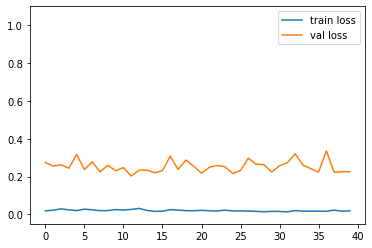

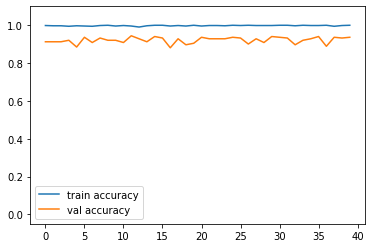

1/1 [==============================] - 0s 185ms/step


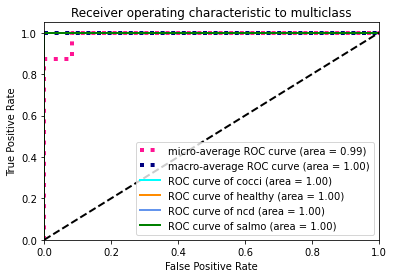

In [33]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_40.h5')

In [34]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=45,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/45
94/94 [==============================] - 36s 378ms/step - loss: 0.0149 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2855 - val_accuracy: 0.9048 - val_auc: 0.9841
Epoch 2/45
94/94 [==============================] - 34s 358ms/step - loss: 0.0153 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2147 - val_accuracy: 0.9405 - val_auc: 0.9908
Epoch 3/45
94/94 [==============================] - 34s 360ms/step - loss: 0.0136 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2133 - val_accuracy: 0.9325 - val_auc: 0.9907
Epoch 4/45
94/94 [==============================] - 34s 357ms/step - loss: 0.0139 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2555 - val_accuracy: 0.9167 - val_auc: 0.9838
Epoch 5/45
94/94 [==============================] - 34s 363ms/step - loss: 0.0118 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2584 - val_accuracy: 0.9167 - val_auc: 0.9867
Epoch 6/45
94/94 [==============================] - 34s 358ms/step - loss: 0.0125 - accuracy: 1.0000 - auc: 1.0000 - val_loss

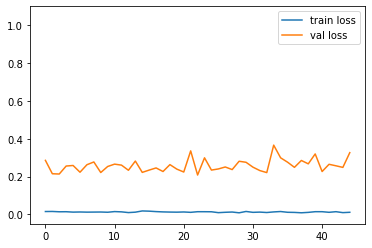

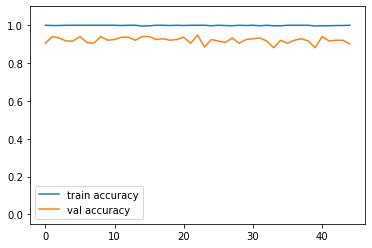

1/1 [==============================] - 0s 29ms/step


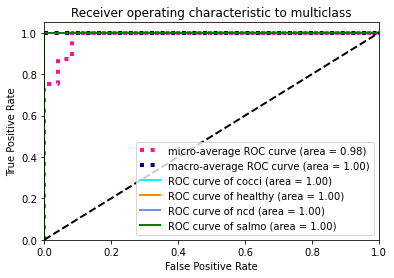

In [35]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_45.h5')

In [36]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
94/94 [==============================] - 34s 359ms/step - loss: 0.0088 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2506 - val_accuracy: 0.9405 - val_auc: 0.9867
Epoch 2/50
94/94 [==============================] - 33s 354ms/step - loss: 0.0154 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.3631 - val_accuracy: 0.8770 - val_auc: 0.9795
Epoch 3/50
94/94 [==============================] - 33s 355ms/step - loss: 0.0130 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2660 - val_accuracy: 0.9286 - val_auc: 0.9843
Epoch 4/50
94/94 [==============================] - 33s 354ms/step - loss: 0.0072 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3056 - val_accuracy: 0.9087 - val_auc: 0.9826
Epoch 5/50
94/94 [==============================] - 34s 360ms/step - loss: 0.0120 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2917 - val_accuracy: 0.9167 - val_auc: 0.9829
Epoch 6/50
94/94 [==============================] - 33s 355ms/step - loss: 0.0121 - accuracy: 1.0000 - auc: 1.0000 - val_loss

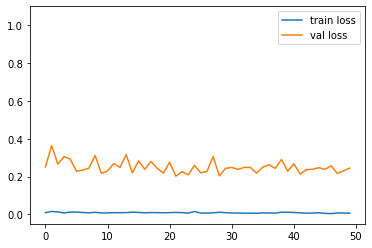

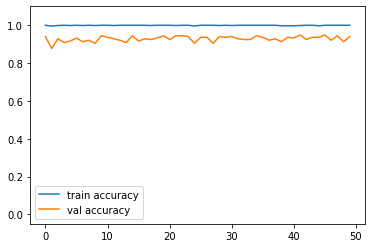

1/1 [==============================] - 0s 28ms/step


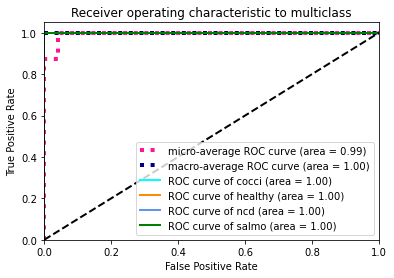

In [37]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_50.h5')

In [29]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=60,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/60
94/94 [==============================] - 39s 408ms/step - loss: 0.3008 - accuracy: 0.9064 - auc: 0.9883 - val_loss: 0.3911 - val_accuracy: 0.8532 - val_auc: 0.9753
Epoch 2/60
94/94 [==============================] - 36s 387ms/step - loss: 0.2878 - accuracy: 0.9037 - auc: 0.9894 - val_loss: 0.3910 - val_accuracy: 0.8571 - val_auc: 0.9742
Epoch 3/60
94/94 [==============================] - 37s 392ms/step - loss: 0.2787 - accuracy: 0.9037 - auc: 0.9904 - val_loss: 0.4149 - val_accuracy: 0.8770 - val_auc: 0.9720
Epoch 4/60
94/94 [==============================] - 36s 386ms/step - loss: 0.2516 - accuracy: 0.9198 - auc: 0.9934 - val_loss: 0.3496 - val_accuracy: 0.8770 - val_auc: 0.9804
Epoch 5/60
94/94 [==============================] - 37s 391ms/step - loss: 0.2547 - accuracy: 0.9198 - auc: 0.9915 - val_loss: 0.3387 - val_accuracy: 0.8968 - val_auc: 0.9817
Epoch 6/60
94/94 [==============================] - 37s 395ms/step - loss: 0.2292 - accuracy: 0.9238 - auc: 0.9941 - val_loss

94/94 [==============================] - 33s 353ms/step - loss: 0.0813 - accuracy: 0.9880 - auc: 0.9996 - val_loss: 0.2943 - val_accuracy: 0.9048 - val_auc: 0.9836
Epoch 48/60
94/94 [==============================] - 33s 354ms/step - loss: 0.0759 - accuracy: 0.9840 - auc: 0.9996 - val_loss: 0.2285 - val_accuracy: 0.9365 - val_auc: 0.9892
Epoch 49/60
94/94 [==============================] - 33s 355ms/step - loss: 0.0790 - accuracy: 0.9880 - auc: 0.9996 - val_loss: 0.2377 - val_accuracy: 0.9286 - val_auc: 0.9893
Epoch 50/60
94/94 [==============================] - 33s 355ms/step - loss: 0.0767 - accuracy: 0.9826 - auc: 0.9996 - val_loss: 0.2706 - val_accuracy: 0.9206 - val_auc: 0.9871
Epoch 51/60
94/94 [==============================] - 33s 353ms/step - loss: 0.0857 - accuracy: 0.9813 - auc: 0.9994 - val_loss: 0.2327 - val_accuracy: 0.9325 - val_auc: 0.9889
Epoch 52/60
94/94 [==============================] - 33s 353ms/step - loss: 0.0801 - accuracy: 0.9826 - auc: 0.9995 - val_loss: 0.26

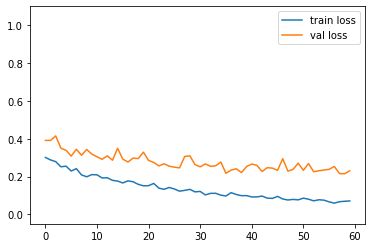

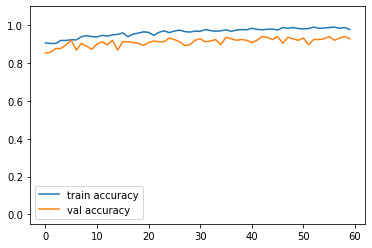

1/1 [==============================] - 0s 26ms/step


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


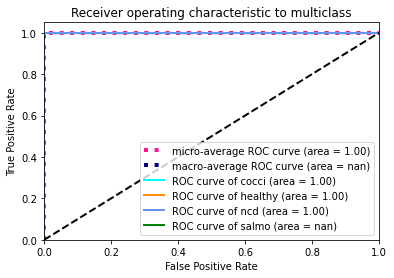

In [30]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_60.h5')

In [31]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=70,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/70
94/94 [==============================] - 34s 361ms/step - loss: 0.0673 - accuracy: 0.9880 - auc: 0.9996 - val_loss: 0.2058 - val_accuracy: 0.9444 - val_auc: 0.9917
Epoch 2/70
94/94 [==============================] - 34s 359ms/step - loss: 0.0578 - accuracy: 0.9880 - auc: 0.9999 - val_loss: 0.2237 - val_accuracy: 0.9405 - val_auc: 0.9904
Epoch 3/70
94/94 [==============================] - 34s 357ms/step - loss: 0.0684 - accuracy: 0.9866 - auc: 0.9996 - val_loss: 0.2024 - val_accuracy: 0.9405 - val_auc: 0.9908
Epoch 4/70
94/94 [==============================] - 33s 356ms/step - loss: 0.0580 - accuracy: 0.9866 - auc: 0.9999 - val_loss: 0.2555 - val_accuracy: 0.9246 - val_auc: 0.9872
Epoch 5/70
94/94 [==============================] - 33s 355ms/step - loss: 0.0643 - accuracy: 0.9826 - auc: 0.9997 - val_loss: 0.2362 - val_accuracy: 0.9365 - val_auc: 0.9892
Epoch 6/70
94/94 [==============================] - 33s 355ms/step - loss: 0.0594 - accuracy: 0.9880 - auc: 0.9998 - val_loss

94/94 [==============================] - 33s 355ms/step - loss: 0.0413 - accuracy: 0.9906 - auc: 0.9999 - val_loss: 0.2102 - val_accuracy: 0.9405 - val_auc: 0.9908
Epoch 48/70
94/94 [==============================] - 33s 352ms/step - loss: 0.0306 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2065 - val_accuracy: 0.9365 - val_auc: 0.9908
Epoch 49/70
94/94 [==============================] - 33s 353ms/step - loss: 0.0297 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2169 - val_accuracy: 0.9286 - val_auc: 0.9901
Epoch 50/70
94/94 [==============================] - 33s 354ms/step - loss: 0.0300 - accuracy: 0.9960 - auc: 1.0000 - val_loss: 0.2396 - val_accuracy: 0.9048 - val_auc: 0.9892
Epoch 51/70
94/94 [==============================] - 33s 354ms/step - loss: 0.0265 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2039 - val_accuracy: 0.9484 - val_auc: 0.9909
Epoch 52/70
94/94 [==============================] - 33s 352ms/step - loss: 0.0382 - accuracy: 0.9920 - auc: 0.9999 - val_loss: 0.22

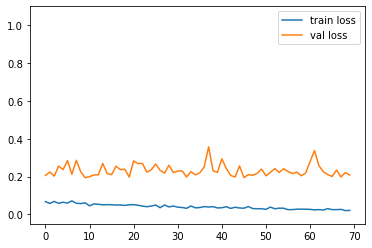

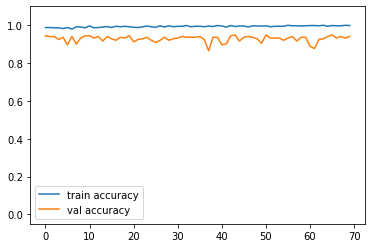

1/1 [==============================] - 0s 20ms/step


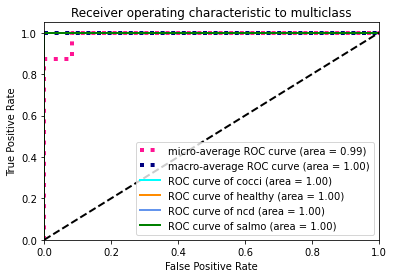

In [33]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_70.h5')

In [40]:
path = 'D:/MScCS/thesis/Dataset/new/separate testing/cocci/'
count = 0
for i in os.listdir(path):
    filename = path + i
    #print(filename)
    #displaying images
    Image(filename,width=224,height=224)
    img = image.load_img(filename,target_size=(224,224))
    #plt.imshow(img)

    #initializing the model to predict the image details using predefined models.
    #model = tf.keras.applications.mobilenet_v2.MobileNetV2()
    resizedimg = image.img_to_array(img)
    finalimg = np.expand_dims(resizedimg,axis=0)
    finalimg = tf.keras.applications.vgg19.preprocess_input(finalimg)
    finalimg.shape
    predictions = model.predict(finalimg)
    category = np.argmax(predictions)
    # To predict and decode the image details
    #results = imagenet_utils.decode_predictions(predictions)
    #print(category)
    if(category == 0):
        count = count + 1
print('Total accurate prediction for cocci:', count)

1/1 [==============================] - 0s 16ms/step
Total accurate prediction for cocci: 8


In [41]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=80,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/80
94/94 [==============================] - 36s 380ms/step - loss: 0.0280 - accuracy: 0.9960 - auc: 0.9999 - val_loss: 0.2428 - val_accuracy: 0.9087 - val_auc: 0.9873
Epoch 2/80
94/94 [==============================] - 33s 352ms/step - loss: 0.0202 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2407 - val_accuracy: 0.9167 - val_auc: 0.9872
Epoch 3/80
94/94 [==============================] - 33s 350ms/step - loss: 0.0195 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2618 - val_accuracy: 0.9048 - val_auc: 0.9864
Epoch 4/80
94/94 [==============================] - 33s 355ms/step - loss: 0.0250 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2704 - val_accuracy: 0.9286 - val_auc: 0.9858
Epoch 5/80
94/94 [==============================] - 35s 371ms/step - loss: 0.0186 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2429 - val_accuracy: 0.9365 - val_auc: 0.9870
Epoch 6/80
94/94 [==============================] - 34s 366ms/step - loss: 0.0249 - accuracy: 0.9960 - auc: 1.0000 - val_loss

94/94 [==============================] - 33s 350ms/step - loss: 0.0136 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2739 - val_accuracy: 0.8929 - val_auc: 0.9846
Epoch 48/80
94/94 [==============================] - 33s 349ms/step - loss: 0.0128 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2811 - val_accuracy: 0.9167 - val_auc: 0.9846
Epoch 49/80
94/94 [==============================] - 33s 350ms/step - loss: 0.0105 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2676 - val_accuracy: 0.9325 - val_auc: 0.9856
Epoch 50/80
94/94 [==============================] - 33s 349ms/step - loss: 0.0096 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2163 - val_accuracy: 0.9444 - val_auc: 0.9876
Epoch 51/80
94/94 [==============================] - 33s 350ms/step - loss: 0.0168 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2233 - val_accuracy: 0.9127 - val_auc: 0.9869
Epoch 52/80
94/94 [==============================] - 33s 351ms/step - loss: 0.0128 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.21

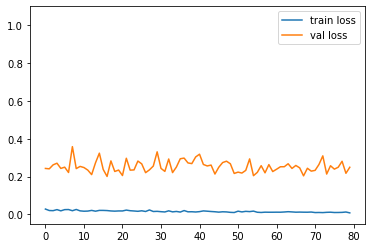

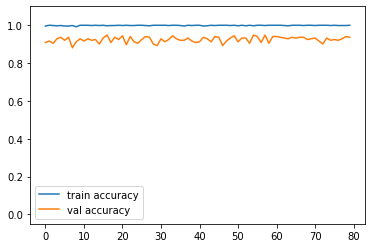

1/1 [==============================] - 0s 28ms/step


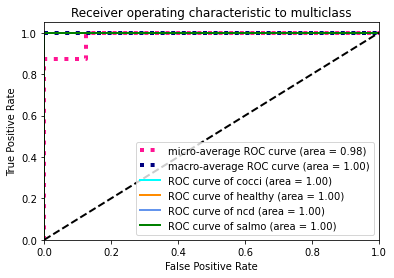

In [42]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_80.h5')

In [43]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=90,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/90
94/94 [==============================] - 34s 362ms/step - loss: 0.0092 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2856 - val_accuracy: 0.9246 - val_auc: 0.9850
Epoch 2/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0156 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2865 - val_accuracy: 0.9167 - val_auc: 0.9834
Epoch 3/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0078 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2522 - val_accuracy: 0.9286 - val_auc: 0.9862
Epoch 4/90
94/94 [==============================] - 34s 357ms/step - loss: 0.0086 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2843 - val_accuracy: 0.9127 - val_auc: 0.9834
Epoch 5/90
94/94 [==============================] - 34s 357ms/step - loss: 0.0077 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2421 - val_accuracy: 0.9246 - val_auc: 0.9867
Epoch 6/90
94/94 [==============================] - 34s 358ms/step - loss: 0.0115 - accuracy: 0.9973 - auc: 1.0000 - val_loss

94/94 [==============================] - 33s 354ms/step - loss: 0.0077 - accuracy: 0.9973 - auc: 1.0000 - val_loss: 0.2781 - val_accuracy: 0.9167 - val_auc: 0.9842
Epoch 48/90
94/94 [==============================] - 33s 354ms/step - loss: 0.0082 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2626 - val_accuracy: 0.9127 - val_auc: 0.9864
Epoch 49/90
94/94 [==============================] - 33s 353ms/step - loss: 0.0068 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2262 - val_accuracy: 0.9444 - val_auc: 0.9878
Epoch 50/90
94/94 [==============================] - 33s 355ms/step - loss: 0.0057 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2306 - val_accuracy: 0.9365 - val_auc: 0.9876
Epoch 51/90
94/94 [==============================] - 33s 353ms/step - loss: 0.0097 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2661 - val_accuracy: 0.9325 - val_auc: 0.9862
Epoch 52/90
94/94 [==============================] - 33s 353ms/step - loss: 0.0194 - accuracy: 0.9947 - auc: 0.9999 - val_loss: 0.29

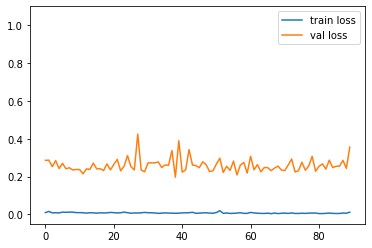

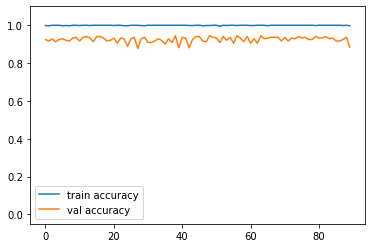

1/1 [==============================] - 0s 24ms/step


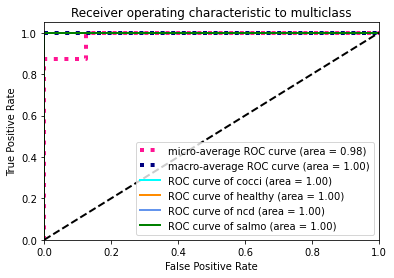

In [44]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_90.h5')

In [45]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/100
94/94 [==============================] - 34s 359ms/step - loss: 0.0050 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2691 - val_accuracy: 0.9246 - val_auc: 0.9851
Epoch 2/100
94/94 [==============================] - 33s 354ms/step - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9286 - val_auc: 0.9861
Epoch 3/100
94/94 [==============================] - 33s 354ms/step - loss: 0.0077 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.9008 - val_auc: 0.9845
Epoch 4/100
94/94 [==============================] - 33s 355ms/step - loss: 0.0077 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.3052 - val_accuracy: 0.9365 - val_auc: 0.9858
Epoch 5/100
94/94 [==============================] - 33s 356ms/step - loss: 0.0046 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2734 - val_accuracy: 0.9325 - val_auc: 0.9866
Epoch 6/100
94/94 [==============================] - 33s 353ms/step - loss: 0.0049 - accuracy: 1.0000 - auc: 1.0000 - va

94/94 [==============================] - 33s 354ms/step - loss: 0.0033 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2503 - val_accuracy: 0.9246 - val_auc: 0.9855
Epoch 48/100
94/94 [==============================] - 33s 352ms/step - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2792 - val_accuracy: 0.9325 - val_auc: 0.9850
Epoch 49/100
94/94 [==============================] - 33s 355ms/step - loss: 0.0041 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2659 - val_accuracy: 0.9325 - val_auc: 0.9853
Epoch 50/100
94/94 [==============================] - 33s 352ms/step - loss: 0.0029 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2547 - val_accuracy: 0.9365 - val_auc: 0.9856
Epoch 51/100
94/94 [==============================] - 33s 352ms/step - loss: 0.0030 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.3434 - val_accuracy: 0.9048 - val_auc: 0.9824
Epoch 52/100
94/94 [==============================] - 33s 352ms/step - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss:

94/94 [==============================] - 33s 353ms/step - loss: 0.0019 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2526 - val_accuracy: 0.9405 - val_auc: 0.9860
Epoch 94/100
94/94 [==============================] - 33s 352ms/step - loss: 0.0043 - accuracy: 0.9987 - auc: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9167 - val_auc: 0.9848
Epoch 95/100
94/94 [==============================] - 33s 351ms/step - loss: 0.0024 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2501 - val_accuracy: 0.9405 - val_auc: 0.9862
Epoch 96/100
94/94 [==============================] - 33s 354ms/step - loss: 0.0023 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2589 - val_accuracy: 0.9405 - val_auc: 0.9857
Epoch 97/100
94/94 [==============================] - 33s 354ms/step - loss: 0.0031 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9365 - val_auc: 0.9880
Epoch 98/100
94/94 [==============================] - 33s 351ms/step - loss: 0.0025 - accuracy: 1.0000 - auc: 1.0000 - val_loss:

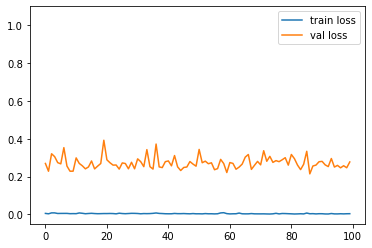

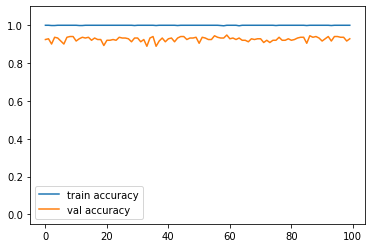

1/1 [==============================] - 0s 26ms/step


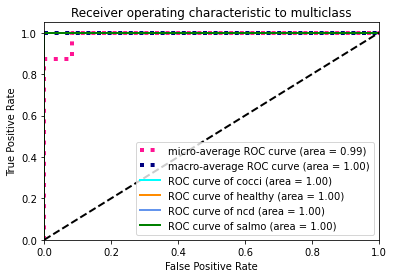

In [46]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/vgg19_100.h5')

In [47]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_prob)
y_score = model.predict(x_test)
y_pred=np.argmax(y_score, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

1/1 [==============================] - 0s 25ms/step
[[3 0 0 0]
 [0 1 0 0]
 [0 0 2 0]
 [0 0 1 1]]


In [49]:
proba = model.predict(separate_test_set)

5/5 [==============================] - 4s 358ms/step


In [50]:
y_probaa = np.argmax(proba, axis=1)
print(y_probaa)

[0 3 1 0 1 1 3 1 0 1 3 0 3 1 0 3 3 1 3 1 0 0 1 3 1 2 3 1 3 0 0 1 3 3 1 0 2
 0 0 0 1 2 0 0 0 0 0 3 2 1 3 3 3 2 0 2 1 1 0 3 1 3 1 3 0 1 0 0 0 0 1 0 3 1
 1 0 3 2 0 2]


In [48]:
separate_test_set = test_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new/separate testing',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')


Found 80 images belonging to 4 classes.
